In [1]:
import sys
import os
from os.path import join, dirname, realpath, exists
import json
import glob
import inspect

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from sklearn import preprocessing
import xarray as xr


import mne
from mne.preprocessing import (ICA, corrmap, create_ecg_epochs,
                             create_eog_epochs)
from mne.datasets.brainstorm import bst_auditory
from mne.io import read_raw_ctf
from mne.preprocessing import annotate_muscle_zscore

mne.set_log_level('error')  # reduce extraneous MNE output

# %matplotlib widget

modules_dir = '../programs/Python_Packages/TMSi_SAGA_Python-V4.0.0.0/' # directory with all modules
measurements_dir = './data_Sorted/' # directory with all measurements
sys.path.append(modules_dir)

from TMSiFileFormats.file_readers import Poly5Reader
from autoreject import get_rejection_threshold

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Load dataset and montage setting

In [227]:
preprocess_dir = './preprocessed_data/'

subject_folders = glob.glob(measurements_dir + 'pongFac23*')
subjects = [subj.split('_')[-1] for subj in subject_folders]

In [228]:
def get_default_args(func):
    signature = inspect.signature(func)
    return {
        k: v.default
        for k, v in signature.parameters.items()
        if v.default is not inspect.Parameter.empty
    }

In [229]:
def find_nearest(array, values):
    # make sure array is a numpy array
    array = np.array(array)

    # get insert positions
    idxs = np.searchsorted(array, values, side="left")
    
    # find indexes where previous index is closer
    prev_idx_is_less = ((idxs == len(array))|(np.fabs(values - array[np.maximum(idxs-1, 0)]) < np.fabs(values - array[np.minimum(idxs, len(array)-1)])))
    idxs[prev_idx_is_less] -= 1
    
    return array[idxs], idxs

In [230]:
def formatData(data, time, timeLocks, binSize, maxLead, maxLag, sr = 120, isComplex = False):
    
    if len(data) != len(time):
        raise Exception('Data and time must have equal length')

    nTrials = len(timeLocks)
    
    rangeInds = np.round(np.array([-maxLead*sr, maxLag*sr], dtype = np.int64))
    
    nearestTimes, nearestInds = find_nearest(time, timeLocks)
    beginInds = nearestInds - rangeInds[0]
    endInds = nearestInds + rangeInds[-1]
    
    fData = np.zeros((np.sum(rangeInds), data.shape[1], nTrials))

    if isComplex:
        fData = fData.astype(complex)
    
    for trialInd in range(nTrials):
        
        trial_data = data[beginInds[trialInd] : endInds[trialInd],:]
        trial_length = trial_data.shape[0]
        
        if trial_length >= fData.shape[0]:
            fData[:, :, trialInd] = trial_data
        else:
            fData[:trial_length, :, trialInd] = trial_data
    
    return fData

In [231]:
def process_pong_session(sub_dir, nTrials = 160, event_label = 'startTrig0', binSize = 1, maxLead = 0.2, maxLag = 3, frame_rate = 120, output_all = True):
    
    behav_dir = os.path.join(sub_dir, 'Pong')

    sub_trials = glob.glob(behav_dir + '/test_*kin_*.csv')
    sub_behav = sub_trials[0].split('_kin_')[0]+'.csv'
    sub_trials = sorted(sub_trials, key=lambda fname: int(fname.split('_kin_')[-1].split('.')[0]))
    
    session_data = pd.read_csv(sub_behav, nrows = nTrials)
    time_locks = session_data[event_label]

    movement_data = []
    
    for trial, trial_file in enumerate(sub_trials):
        trialdf = pd.read_csv(trial_file)
        movement_data.append(trialdf)
        
        if trial == 0:
            mvm = trialdf['p1x']
            tst = trialdf['t']
            by = trialdf['by']
            bx = trialdf['bx']
        else:
            mvm = np.concatenate((mvm, trialdf['p1x']))
            tst = np.concatenate((tst, trialdf['t']))
            by = np.concatenate((by, trialdf['by']))
            bx = np.concatenate((bx, trialdf['bx']))

    mvm = mvm.reshape(-1,1)
    tst = tst.reshape(-1,1)
    by = by.reshape(-1,1)
    bx = bx.reshape(-1,1)
        
    if output_all:
        binned_data_trials = formatData(np.concatenate((mvm, tst, by, bx), axis = 1), tst.squeeze(), time_locks, binSize, maxLead, maxLag, sr = frame_rate)
    else:    
        binned_data_trials = formatData(mvm, tst.squeeze(), time_locks, binSize, maxLead, maxLag, sr = frame_rate).squeeze()

    return session_data, movement_data, binned_data_trials

# Save processed data

In [ ]:
session_results_agg = []
movement_trials_agg = []
agg_movements = []

for sub_ind, sub_dir in enumerate(subject_folders):
    session_data, movement_data, binned_mvms = process_pong_session(sub_dir)
    session_results_agg.append(session_data)
    movement_trials_agg.append(movement_data)
    agg_movements.append(binned_mvms)

agg_movements = np.array(agg_movements)
agg_movements = np.transpose(agg_movements, (1,3,2,0))

In [204]:
relevant_beh_columns = ['BDP_new', 'BAP_new', 'BDP', 'BAP', 'offset', 'ballX', 'ms',
 'ballSpeedX', 'ballSpeedY','text.started', 'startTrig0',
 'startTrig1', 'threshTime', 'feedbackTime', 'result', 'cond',
 'participant','age', 'gender', 'condOrder','Number']

session_dims = ('variable', 'trial', 'subject')
session_coords = {'variable': relevant_beh_columns, 'subject': subjects}

results_array = []

for sInd, session_results in enumerate(session_results_agg):    
    df = session_results[relevant_beh_columns].copy()
    subj = df.loc[0,'participant']
    mapd = {'n': -1, 'p': 1, 'a-p': 0.1, 'p-a': 1.0, 'male' : 1, 'female' : 2, subj: int(subj.split('p')[-1])}
    df = df.replace(mapd).to_numpy()
    results_array.append(df)
results_array = np.transpose(np.array(results_array), (2,1,0))
results_array=xr.DataArray(results_array, dims = session_dims, coords = session_coords)
results_array.to_netcdf(preprocess_dir + 'agg_pong_results.nc')

In [205]:
maxLead = 0.2
maxLag = 3.0

mvm_data_dims = ('time', 'trial', 'source', 'subject')
mvm_data_coords = {'source': ['movement', 'timestamp', 'ball_y', 'ball_x'], 'subject': subjects}
mvm_data_attrs = {'max_lead' : maxLead, 'max_lag' : maxLag, 'center_event': get_default_args(process_pong_session)['event_label']}

movement_array = xr.DataArray(agg_movements, dims = mvm_data_dims, coords = mvm_data_coords, attrs = mvm_data_attrs)
movement_array.to_netcdf(preprocess_dir + 'agg_pong_movement.nc')

# Load processed data

In [206]:
mapped_dict = {-1: 'n', 1: 'p', 0.1: 'a-p', 1.0: 'p-a', 1: 'male', 2: 'female'}
 
results_array = xr.load_dataarray(preprocess_dir + 'agg_pong_results.nc')
movement_array_raw = xr.load_dataarray(preprocess_dir + 'agg_pong_movement.nc')
results_array.load()
movement_array_raw.load()

<xarray.DataArray (time: 336, trial: 160, source: 4, subject: 16)>
array([[[[ 9.99949365e+00, -2.72056341e+00, -1.27097605e+01, ...,
          -6.36486293e-01,  5.11269202e+00, -6.96058233e+00],
         [ 1.31721674e+02,  1.21413797e+02,  1.21835539e+02, ...,
           1.51305112e+02,  1.58129187e+02,  1.75679081e+02],
         [ 3.25985440e+02,  3.51873890e+02,  3.25805915e+02, ...,
           3.25471763e+02,  3.52004181e+02,  3.51860973e+02],
         [-2.97000000e+02, -3.26873890e+02, -6.46537277e+02, ...,
          -1.86842746e+02,  2.87002787e+02,  5.51814630e+02]],

        [[-6.17007033e+00, -1.28326885e+00,  2.52556177e+00, ...,
           1.59132029e+00,  6.83744553e+00,  5.18455675e+00],
         [ 1.35388280e+02,  1.25905274e+02,  1.26102167e+02, ...,
           1.56396829e+02,  1.63754062e+02,  1.80987463e+02],
         [ 3.51987520e+02,  3.25852871e+02,  3.25805915e+02, ...,
           3.51547226e+02,  3.52004181e+02,  3.51860973e+02],
         [-2.97991680e+02,  3.41137162e+02,  1.38268638e+02, ...,
          -6.74849075e+02,  3.04998606e+02, -6.55953658e+02]],

        [[-1.34284077e+01, -5.95447615e+00, -8.54160633e+00, ...,
           4.41484633e-01, -3.49027380e-01,  4.75336837e+00],
...
         [-1.24340072e+03,  1.08002855e+03, -3.56192952e+01, ...,
          -1.25095533e+02, -8.81310759e+02, -8.47755309e+02]],

        [[-8.39787687e+00, -2.28426867e+01, -2.36123977e+00, ...,
           1.30178123e+01,  2.99542620e+02, -3.28318832e+01],
         [ 9.46130035e+02,  9.48787512e+02,  9.37176675e+02, ...,
           9.95847187e+02,  1.07565402e+03,  1.02491885e+03],
         [ 4.40978409e+02,  6.82140662e+02,  5.00992535e+02, ...,
           8.37469251e+02,  2.91613061e+02,  5.01994653e+02],
         [ 1.39902666e+03, -6.83583665e+02, -3.96716432e+01, ...,
          -2.74627542e+02, -1.07858703e+03,  4.99821760e+00]],

        [[ 1.11493293e+01,  8.27474012e+00,  1.06462762e+01, ...,
          -2.46393048e+01,  3.86283446e+02, -1.73091029e+01],
         [ 9.50221742e+02,  9.53887235e+02,  9.40468145e+02, ...,
           1.00073896e+03,  1.08181243e+03,  1.02935224e+03],
         [ 6.82013920e+02,  1.04743573e+03,  1.04757479e+03, ...,
           6.82505018e+02,  6.81995337e+02,  6.82155069e+02],
         [ 1.01205776e+03, -1.73802855e+03, -1.72146320e+03, ...,
          -7.48191066e+02,  3.40193496e+01, -7.15643446e+02]]]])
Coordinates:
  * source   (source) object 'movement' 'timestamp' 'ball_y' 'ball_x'
  * subject  (subject) object 'p01' 'p02' 'p03' 'p04' ... 'p19' 'p27' 'p28'
Dimensions without coordinates: time, trial
Attributes:
    max_lead:      0.2
    max_lag:       3.0
    center_event:  startTrig0

In [207]:
f_order = 3
low_cut = 15

lowpass = signal.butter(f_order, low_cut, fs = 1000, btype = 'lp', output = 'sos') 

movement_array = signal.sosfiltfilt(lowpass, movement_array_raw, axis = 0)
movement_array = xr.DataArray(movement_array, dims = movement_array_raw.dims, coords = movement_array_raw.coords, attrs = movement_array_raw.attrs)

In [208]:
conditions = results_array.sel(variable = 'cond')
intercepts = results_array.sel(variable = 'result')

In [209]:
pcond = conditions == 1
acond = conditions == 0

negfb = intercepts == -1
posfb = intercepts == 1

# ptrials = (pcond) & (posfb)
# atrials = (acond) & (posfb)

ptrials = (pcond) & (negfb)
atrials = (acond) & (negfb)

ptrials = ptrials.stack(aggTrials = ('trial', 'subject'))
atrials = atrials.stack(aggTrials = ('trial', 'subject'))

bap_stacked = results_array.sel(variable = 'BAP_new').stack(aggTrials = ('trial', 'subject'))
mvm_stacked = movement_array.stack(aggTrials = ('trial', 'subject'))

In [210]:
p_bap = bap_stacked.where(ptrials).dropna(dim = 'aggTrials')
a_bap = bap_stacked.where(atrials).dropna(dim = 'aggTrials')

pms = mvm_stacked.sel(source = 'movement').where(ptrials).dropna(dim = 'aggTrials')
ams = mvm_stacked.sel(source = 'movement').where(atrials).dropna(dim = 'aggTrials')

pms = pms/p_bap
ams = ams/a_bap

pms = np.abs(pms)
ams = np.abs(ams)

condMaxs = np.array([pms.max(), ams.max()])

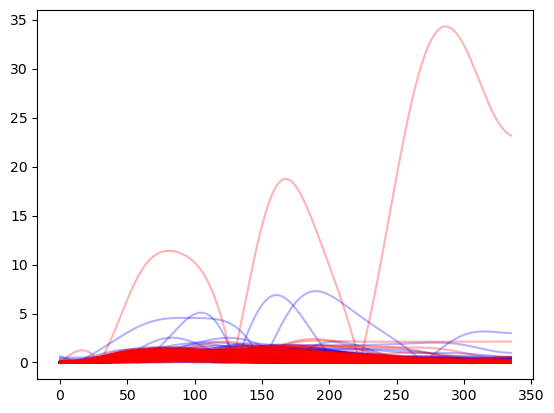

In [212]:
plt.plot(pms, 'b', alpha = 0.3);plt.plot(ams, 'r', alpha = 0.3);